<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Process-and-add-up-all-provinces/states-into-one-row-per-country" data-toc-modified-id="Process-and-add-up-all-provinces/states-into-one-row-per-country-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Process and add up all provinces/states into one row per country</a></span></li><li><span><a href="#List-of-all-affected-countries" data-toc-modified-id="List-of-all-affected-countries-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>List of all affected countries</a></span></li></ul></li><li><span><a href="#Current-situation-plots" data-toc-modified-id="Current-situation-plots-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Current situation plots</a></span><ul class="toc-item"><li><span><a href="#Plot-trends-over-calendar-date-in-selected-countries" data-toc-modified-id="Plot-trends-over-calendar-date-in-selected-countries-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Plot trends over calendar date in selected countries</a></span></li><li><span><a href="#Stats-per-million-population" data-toc-modified-id="Stats-per-million-population-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Stats per million population</a></span></li><li><span><a href="#Plot-trends-over-days-since-start-of-local-outbreak-in-selected-countries" data-toc-modified-id="Plot-trends-over-days-since-start-of-local-outbreak-in-selected-countries-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot trends over days since start of local outbreak in selected countries</a></span></li><li><span><a href="#Case-fatality-rate-per-country" data-toc-modified-id="Case-fatality-rate-per-country-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Case fatality rate per country</a></span></li><li><span><a href="#Cases-by-continent" data-toc-modified-id="Cases-by-continent-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Cases by continent</a></span></li><li><span><a href="#Smoothed-growth-factor" data-toc-modified-id="Smoothed-growth-factor-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Smoothed growth factor</a></span></li><li><span><a href="#New-confirmed/Active-case-ratio" data-toc-modified-id="New-confirmed/Active-case-ratio-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>New confirmed/Active case ratio</a></span></li><li><span><a href="#Stats-for-some-other-countries,-using-linear-scale" data-toc-modified-id="Stats-for-some-other-countries,-using-linear-scale-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Stats for some other countries, using linear scale</a></span></li><li><span><a href="#Pie-charts" data-toc-modified-id="Pie-charts-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Pie charts</a></span></li><li><span><a href="#Country-highlight" data-toc-modified-id="Country-highlight-2.10"><span class="toc-item-num">2.10&nbsp;&nbsp;</span>Country highlight</a></span></li></ul></li><li><span><a href="#Forecast-plots" data-toc-modified-id="Forecast-plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Forecast plots</a></span><ul class="toc-item"><li><span><a href="#Fit-a-logistic-curve-and-extrapolate-number-of-future-cases" data-toc-modified-id="Fit-a-logistic-curve-and-extrapolate-number-of-future-cases-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Fit a logistic curve and extrapolate number of future cases</a></span></li><li><span><a href="#Modelling-fatality-probability-per-day-of-being-infected" data-toc-modified-id="Modelling-fatality-probability-per-day-of-being-infected-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Modelling fatality probability per day of being infected</a></span></li><li><span><a href="#Generate-history-of-active-cases;-how-many-people-have-been-sick-for-how-long?" data-toc-modified-id="Generate-history-of-active-cases;-how-many-people-have-been-sick-for-how-long?-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generate history of active cases; how many people have been sick for how long?</a></span></li><li><span><a href="#Simulate-future-development-based-on-history-and-probability-models" data-toc-modified-id="Simulate-future-development-based-on-history-and-probability-models-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Simulate future development based on history and probability models</a></span></li><li><span><a href="#Mitigation-effectiveness" data-toc-modified-id="Mitigation-effectiveness-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Mitigation effectiveness</a></span></li></ul></li></ul></div>

# COVID-19 data visualization

This generates a series of visualizations from the raw data tables, showing some aspects of the ongoing Covid-19 epidemic that I couldn't find in other reports. Data from Johns Hopkins University.

An earlier version of the plot of cases per country since the start of the local outbreak was shared on Reddit [here](https://www.reddit.com/r/dataisbeautiful/comments/ff9jn4/oc_number_of_cases_per_country_counting_from_the/).   Another plot, of the average growth factor per country, was posted [here](https://www.reddit.com/r/dataisbeautiful/comments/fliec2/oc_covid19_growth_factor_over_time_in_various/).

Note that the Table of Contents links above don't work in the Github preview, but they do on [nbviewer](https://nbviewer.jupyter.org/github/JeroenKools/covid19/tree/master/).

Want to see these graphs for some other countries, or modify the values for the simulations? The easiest and quickest way to run the notebook and make modifications yourself is to open this notebook in [Colab](https://colab.research.google.com/github/JeroenKools/covid19/blob/master/COVID-19.ipynb) or [Binder](https://hub-binder.mybinder.ovh/user/jeroenkools-covid19-wt257qfb/notebooks/COVID-19.ipynb).

## Setup

Import code and parameters from [`covid19_util.py`](covid19_util.py) and [`covid_processing.py`](covid19_processing.py).

Do some additional setup in case the notebook is being run on Google Colab.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
is_colab = 'google.colab' in sys.modules
if is_colab:
    if not "covid19" in sys.path:
        try:
            !git clone https://github.com/JeroenKools/covid19.git
        except e: 
            pass
    try:
        import geonamescache
    except ModuleNotFoundError:
        !pip install geonamescache
        import geonamescache
    sys.path.append("covid19")
    
from covid19_util import *
from covid19_processing import *

In [2]:
data = Covid19Processing()

### Raw confirmed cases data, per region/state

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,...,84,94,110,110,120,170,174
1,NaN,Albania,41.153300,20.168300,0,0,0,...,146,174,186,197,212,223,243
2,NaN,Algeria,28.033900,1.659600,0,0,0,...,302,367,409,454,511,584,716
3,NaN,Andorra,42.506300,1.521800,0,0,0,...,188,224,267,308,334,370,376
4,NaN,Angola,-11.202700,17.873900,0,0,0,...,3,4,4,5,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,Turks and Caicos Islands,United Kingdom,21.694000,-71.797900,0,0,0,...,0,0,0,4,4,5,5
252,NaN,MS Zaandam,0.000000,0.000000,0,0,0,...,0,0,0,2,2,2,2
253,NaN,Botswana,-22.328500,24.684900,0,0,0,...,0,0,0,0,0,3,4
254,NaN,Burundi,-3.373100,29.918900,0,0,0,...,0,0,0,0,0,0,2


### Process and add up all provinces/states into one row per country 

This also adds in a few data points for China from before the start of the Johns Hopkins data, from [Wikipedia](https://en.wikipedia.org/wiki/Timeline_of_the_2019%E2%80%9320_coronavirus_outbreak_in_December_2019_%E2%80%93_January_2020).

Then, display summaries of the confirmed cases by country and by continent.

In [3]:
data.process(rows=20, debug=False)

### Table of confirmed cases by country

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31
Country/Region,,,,,,,,,,,
Afghanistan,0,0,0,0,0,...,110,110,120,170,174
Albania,0,0,0,0,0,...,186,197,212,223,243
Algeria,0,0,0,0,0,...,409,454,511,584,716
Andorra,0,0,0,0,0,...,267,308,334,370,376
Angola,0,0,0,0,0,...,4,5,7,7,7
Antigua and Barbuda,0,0,0,0,0,...,7,7,7,7,7
Argentina,0,0,0,0,0,...,589,690,745,820,1054
Armenia,0,0,0,0,0,...,329,407,424,482,532
Australia,0,0,0,0,0,...,3143,3640,3984,4361,4559


### Table of confirmed cases by continent/region

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31
Asia,45,62,218,554,653,...,147703,155031,162329,169303,178056
Europe,0,0,0,0,0,...,319718,356365,385858,416861,452132
Africa,0,0,0,0,0,...,3885,4225,4786,5196,5781
North America,0,0,0,1,1,...,108800,130023,150609,173024,201071
South America,0,0,0,0,0,...,8856,10144,11197,12180,14386
Oceania,0,0,0,0,0,...,3517,4097,4504,4956,5212
All except China,0,0,0,7,11,...,511394,578707,637995,700167,775208
World,45,62,218,555,654,...,593291,660706,720117,782365,857487


### List of all affected countries

In [4]:
data.list_countries()

### 180 countries/territories affected:


Afghanistan          Albania              Algeria              Andorra              Angola              
Antigua and Barbuda  Argentina            Armenia              Australia            Austria             
Azerbaijan           Bahamas              Bahrain              Bangladesh           Barbados            
Belarus              Belgium              Belize               Benin                Bhutan              
Bolivia              Bosnia and Herzego.  Botswana             Brazil               Brunei              
Bulgaria             Burkina Faso         Burma                Burundi              Cambodia            
Cameroon             Canada               Cape Verde           Central African Re.  Chad                
Chile                China                Colombia             Congo (Brazzaville)  Congo (Kinshasa)    
Costa Rica           Croatia              Cuba                 Cyprus               Czechia             
Denmark              Diamond Princess     Djibouti     

## Current situation plots

### Plot trends over calendar date in selected countries

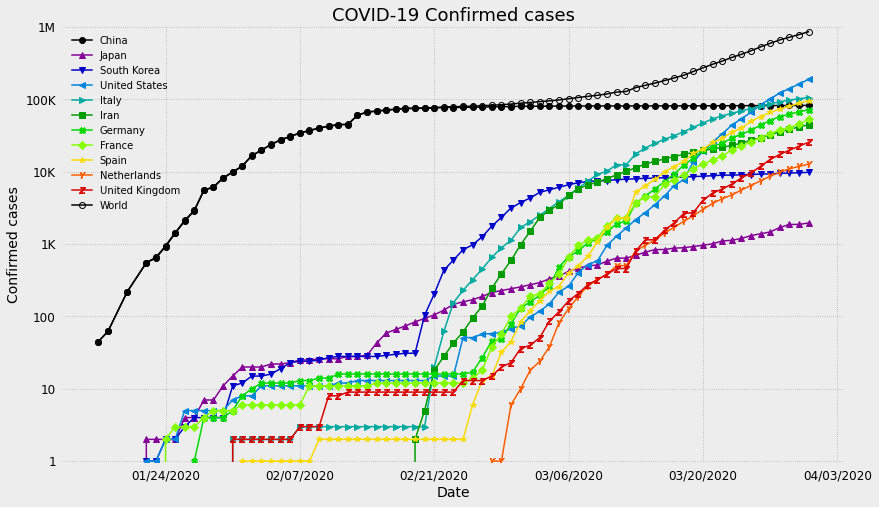

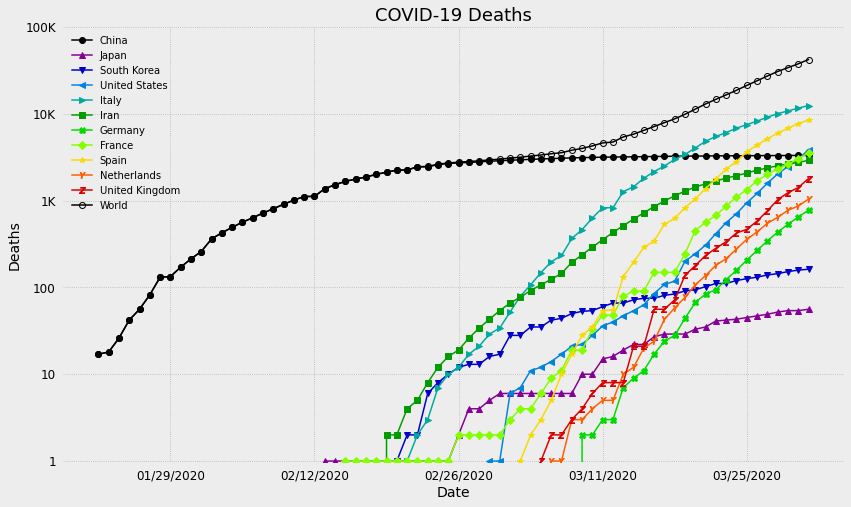

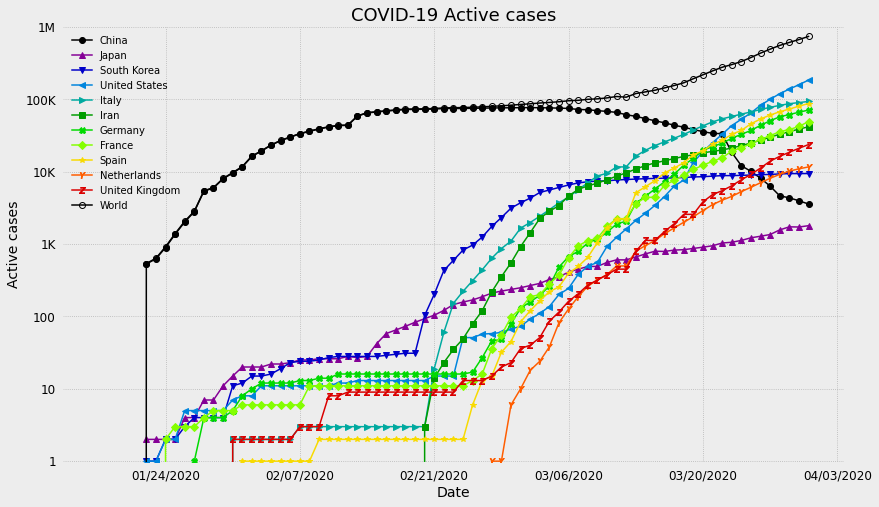

In [5]:
countries_to_plot = ["China", "Japan", "South Korea", "United States", "Italy", "Iran", "Germany",
                     "France", "Spain", "Netherlands", "United Kingdom", "World"]

for y_metric in ["confirmed", "deaths", "active"]:
    data.plot("calendar_date", y_metric, countries_to_plot)

### Stats per million population

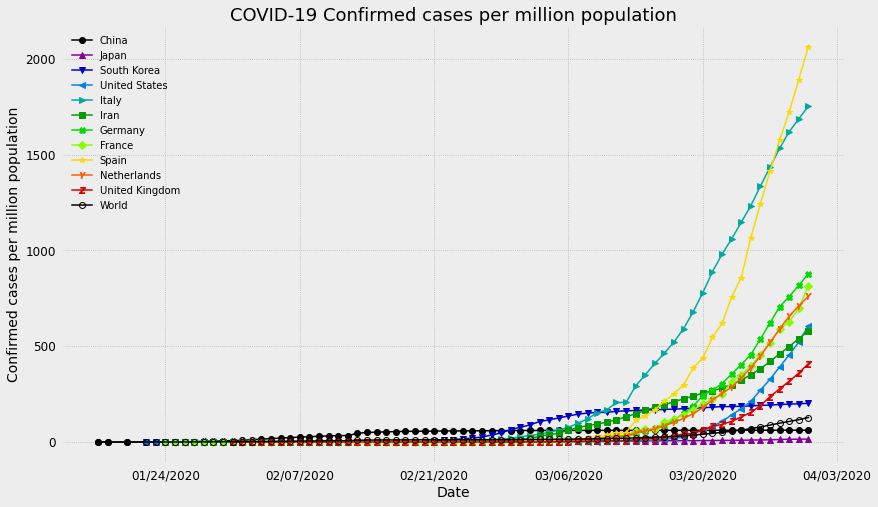

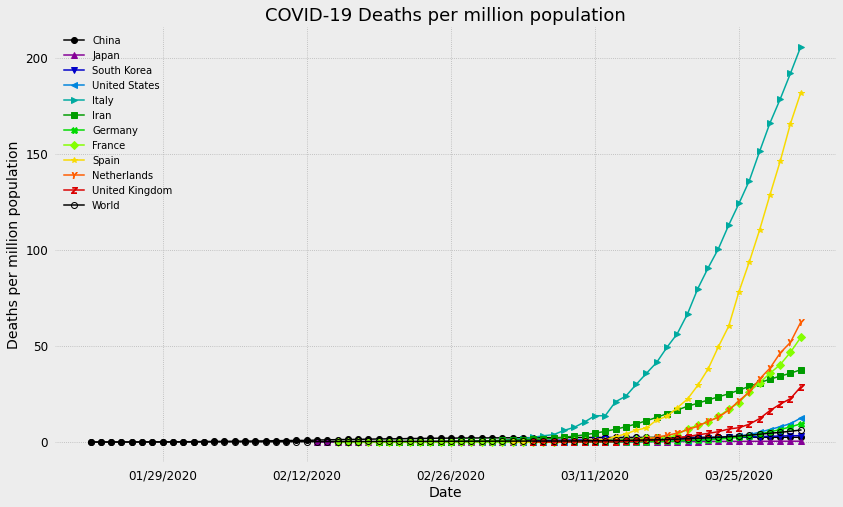

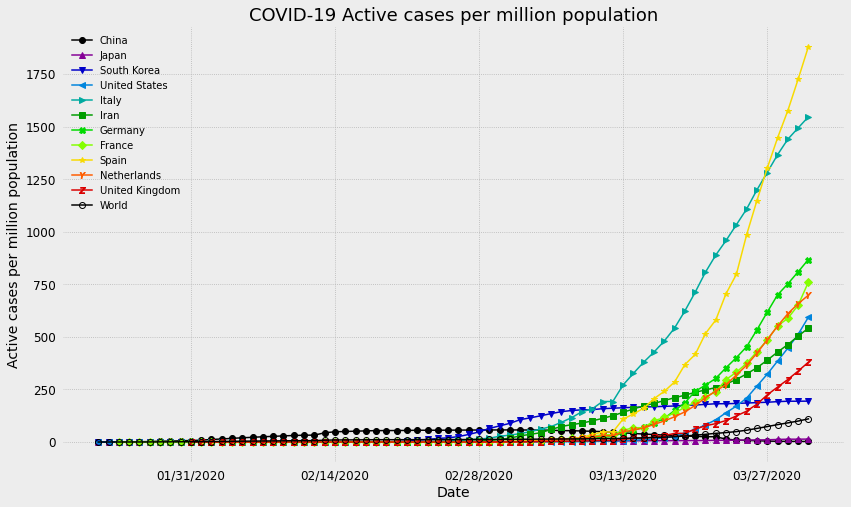

In [6]:
for y_metric in ["confirmed/population", "deaths/population", "active/population"]:
    data.plot("calendar_date", y_metric, countries_to_plot)

### Plot trends over days since start of local outbreak in selected countries

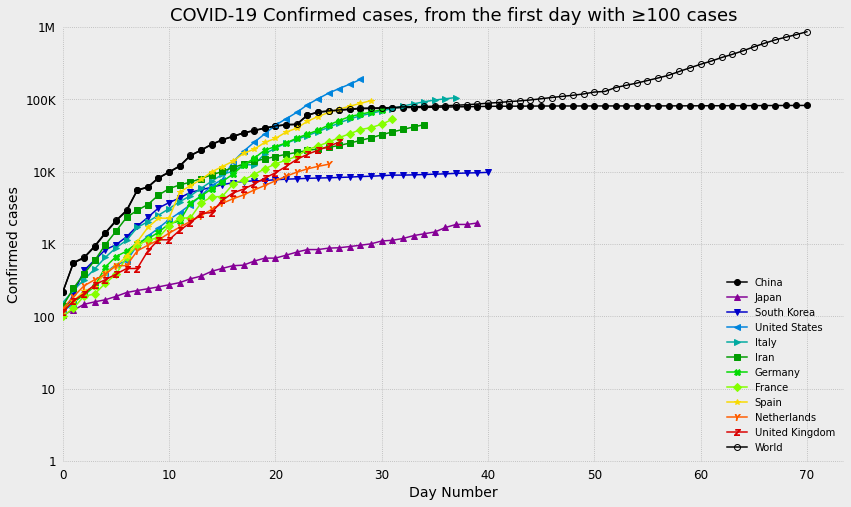

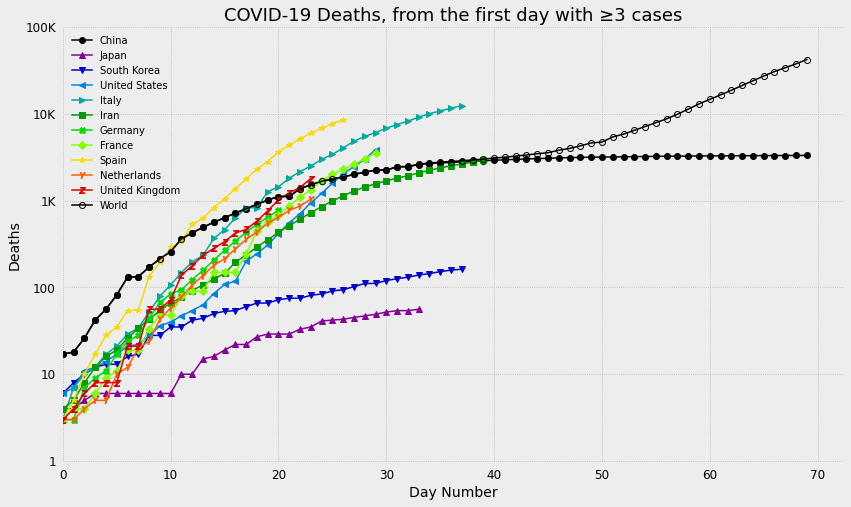

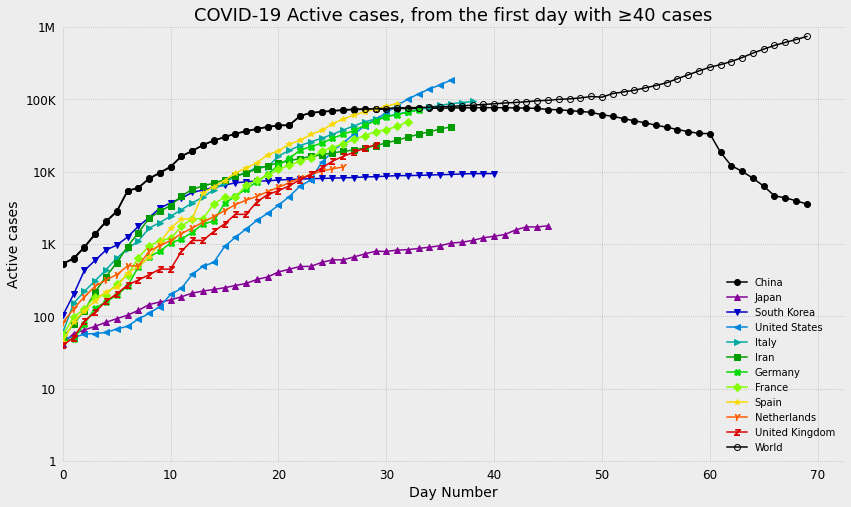

In [7]:
data.plot("day_number", "confirmed", countries_to_plot, min_cases=100)
data.plot("day_number", "deaths", countries_to_plot, min_cases=3)
data.plot("day_number", "active", countries_to_plot, min_cases=40)

### Case fatality rate per country

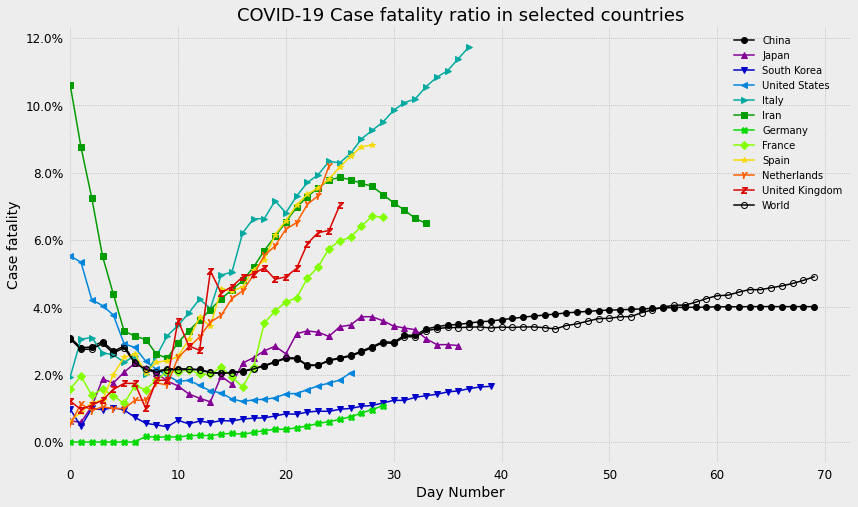

In [8]:
data.plot("day_number", "deaths/confirmed", countries_to_plot, min_cases=150, use_log_scale=False)

### Cases by continent

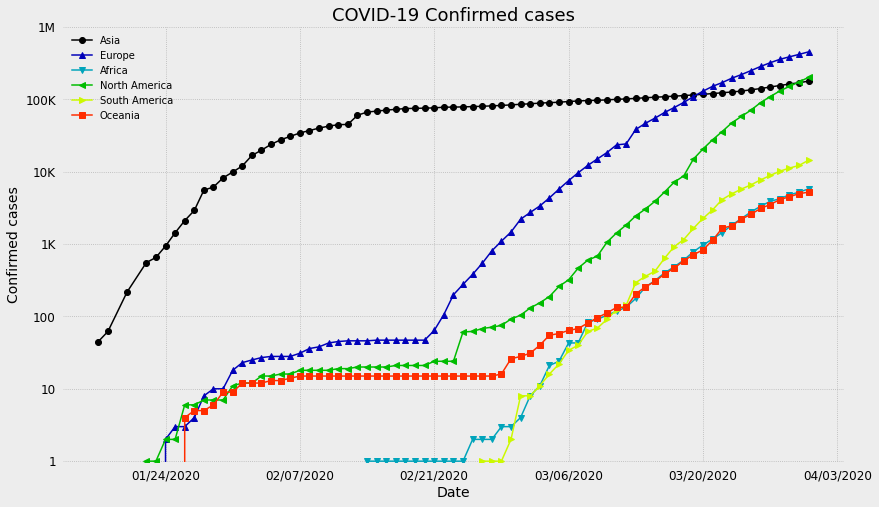

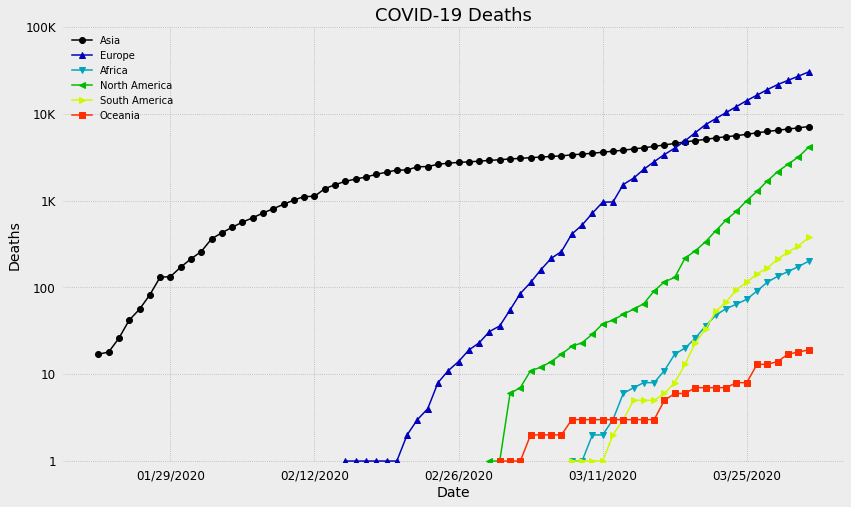

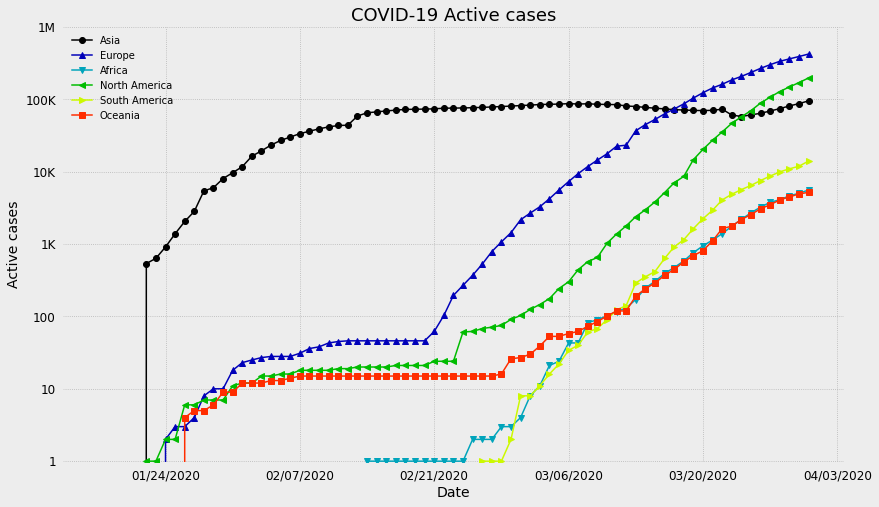

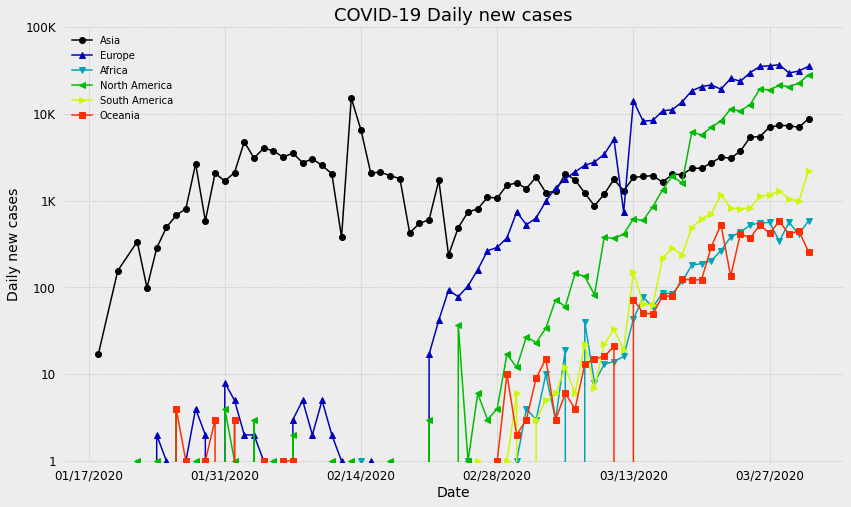

In [9]:
continents = ["Asia", "Europe", "Africa", "North America", "South America", "Oceania"]

for y_metric in ["confirmed", "deaths", "active", "new confirmed"]:
    data.plot("calendar_date", y_metric, continents, fixed_country_colors=False)

### Smoothed growth factor

The growth factor is the multiplier for the number of **new** cases per day. <br>For example, if there are 100 new cases on day *n* and 150 new cases on day *n+1*, the growth factor is 1.5.

* A growth factor larger than 1 means the outbreak is accelerating; it is growing exponentially.
* A growth factor of 1 means the outbreak is growing linearly.
* A growth factor of less than 1 means the outbreak is still growing, but slowing down.
* A growth factor of 0 means there are no new cases.

In this plot, the growth factor is averaged over 5 days to smooth out some large day-to-day variations. 

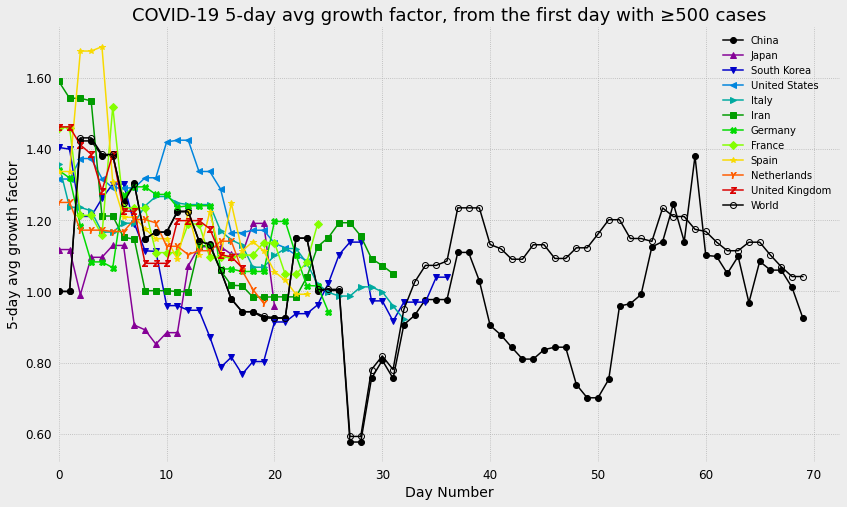

In [10]:
data.plot("day_number", "growth_factor", countries_to_plot, min_cases=500, sigma=5, 
          fixed_country_colors=False, use_log_scale=False)    

### New confirmed/Active case ratio

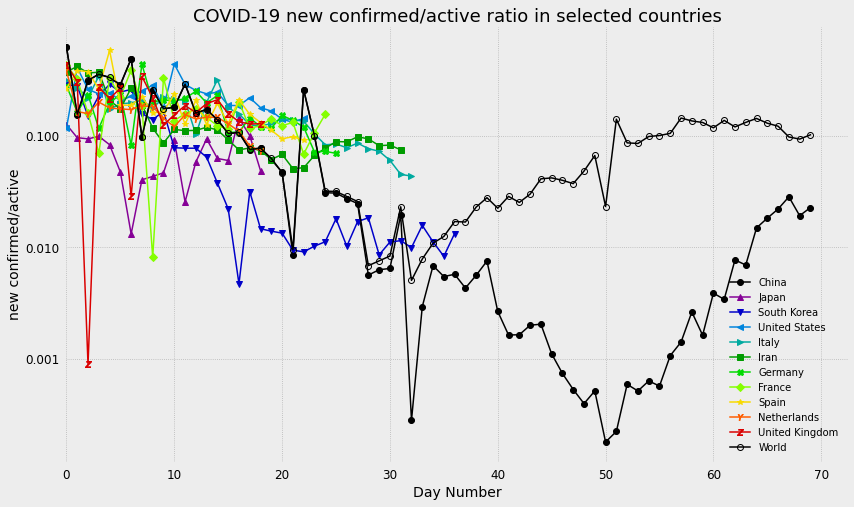

In [11]:
data.plot("day_number", "new confirmed/active", countries_to_plot, min_cases=500, use_log_scale=1)

### Stats for some other countries, using linear scale

This shows how on a linear Y-axis, it becomes hard to examine the trend in all but the top few countries.

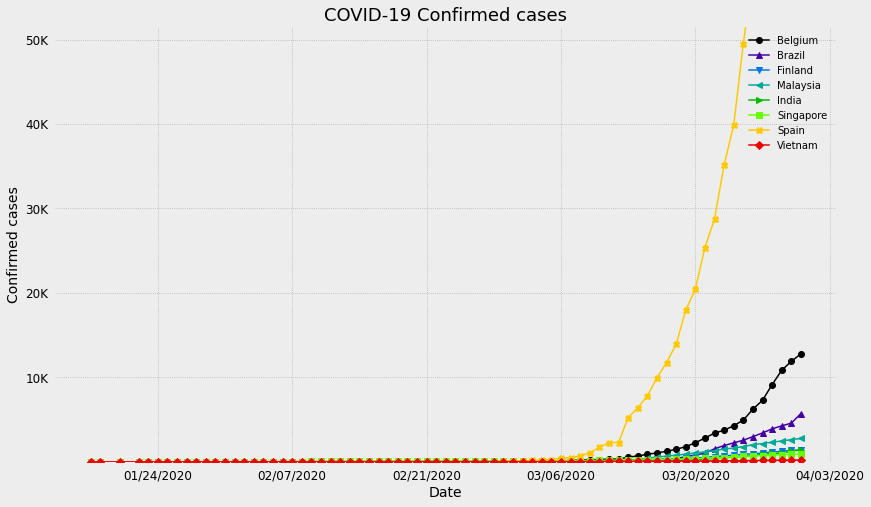

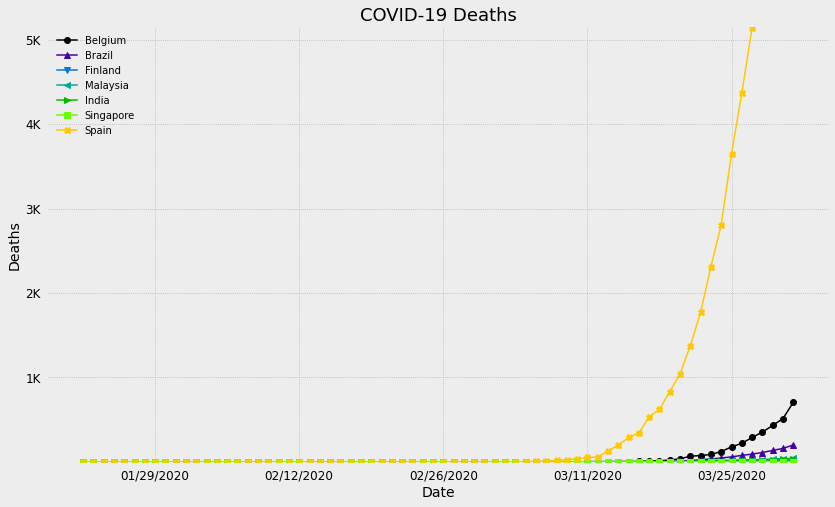

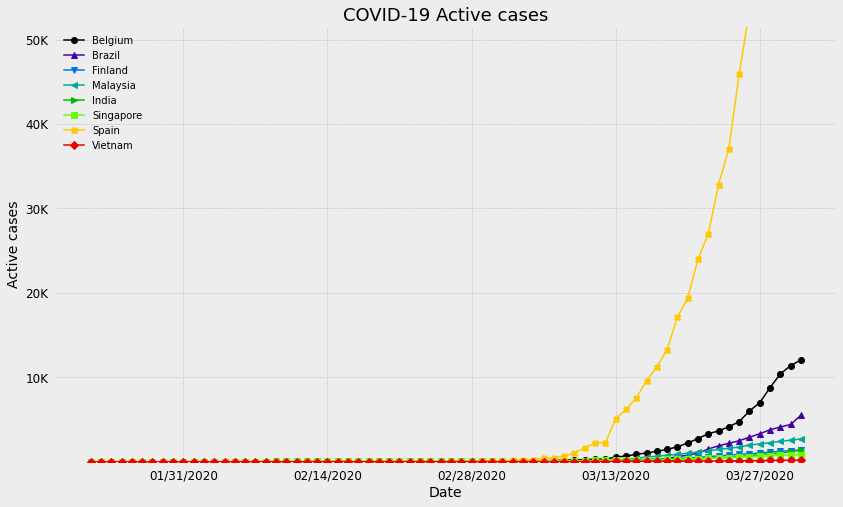

In [12]:
for y_metric in ["confirmed", "deaths", "active"]:
    data.plot("calendar_date", y_metric, 
         ["Belgium", "Brazil", "Finland", "Malaysia", "India", "Singapore", "Spain", "Vietnam"],
         use_log_scale=False)

### Pie charts

Everybody loves pie charts.

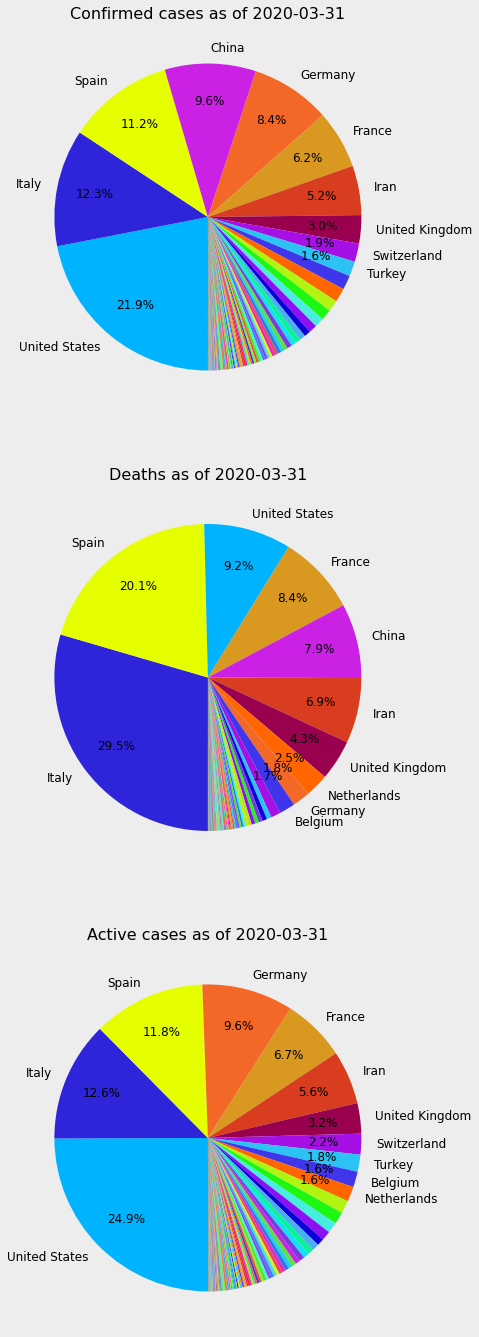

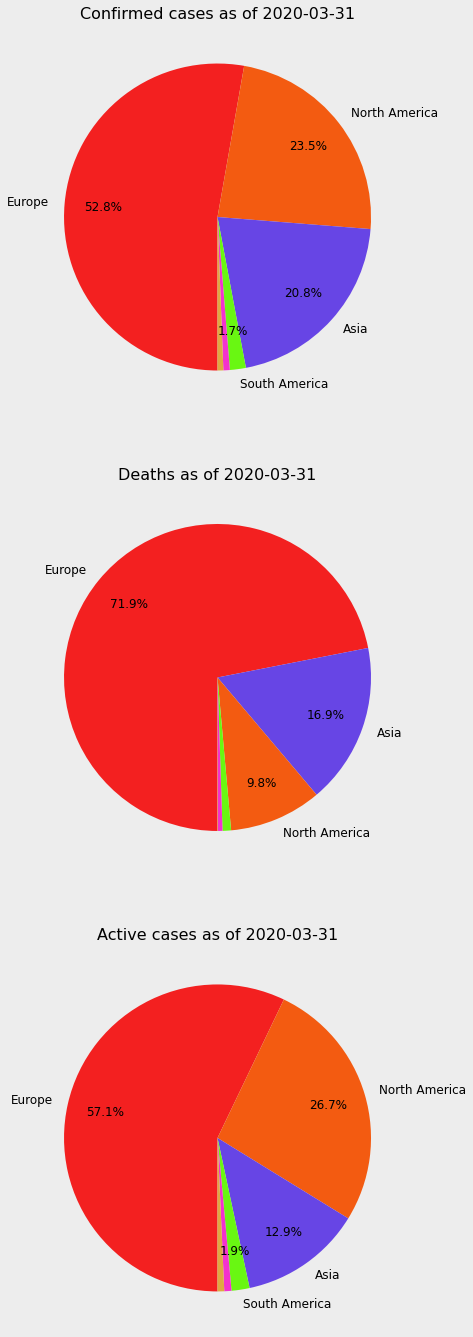

In [13]:
for mode in ["country", "continent"]:
    data.plot_pie(["confirmed cases", "deaths", "active cases"], mode)

### Country highlight

,new_cases,new_deaths
2020-03-25,12038,236
2020-03-26,18058,267
2020-03-27,17821,372
2020-03-28,19821,445
2020-03-29,19408,441
2020-03-30,20921,511
2020-03-31,26365,895


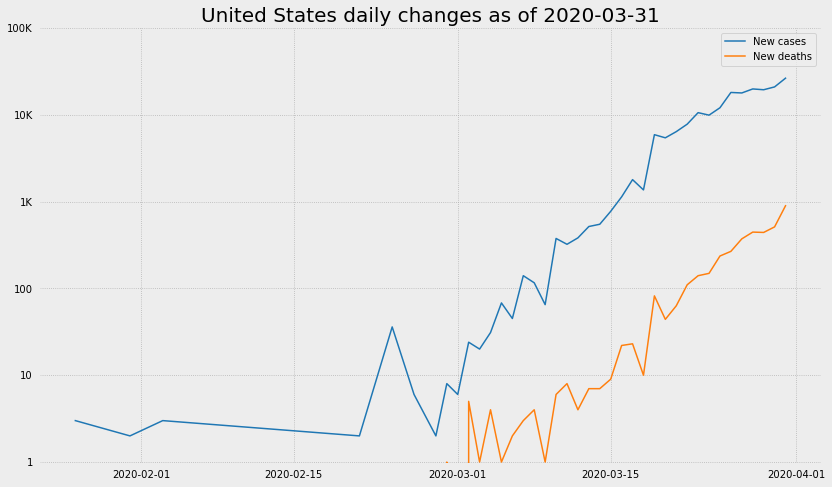

In [14]:
data.country_highlight("United States")

## Forecast plots

First, model the probability distribution of dying after a given number of days.

We can consider a case recovered if they survive for a long enough time.

### Fit a logistic curve and extrapolate number of future cases

This tries to fit a [logistic](https://en.wikipedia.org/wiki/Logistic_function) or 'S-shape' curve to the data so far. While it is reasonable to expect that the total number of cases in any epidemic will eventually roughly have such a shape, the crucial parameters are difficult to predict. For example, changes in spread rate due to policy changes, or the possibility of a second wave of infections from another country are not captured at all.

For some countries the results look plausible enough, while for some others it can give extremely unlikely results, like predicting a number of cases that's many times the country's population.

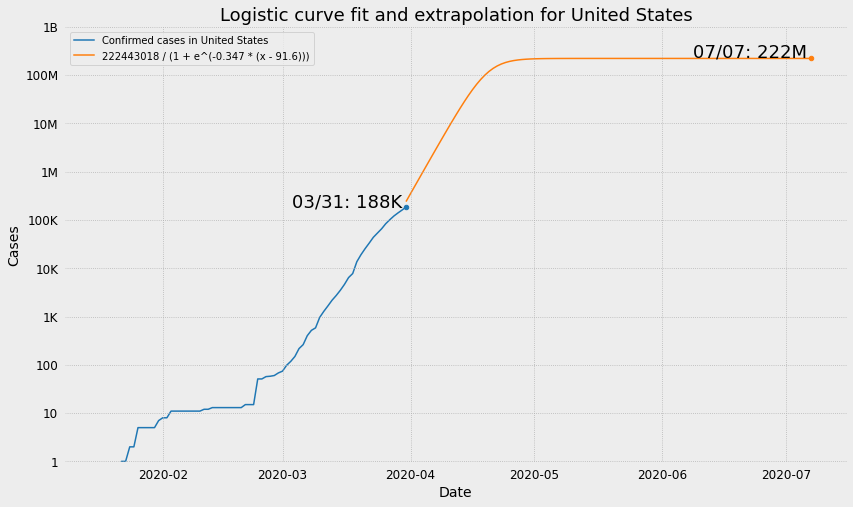

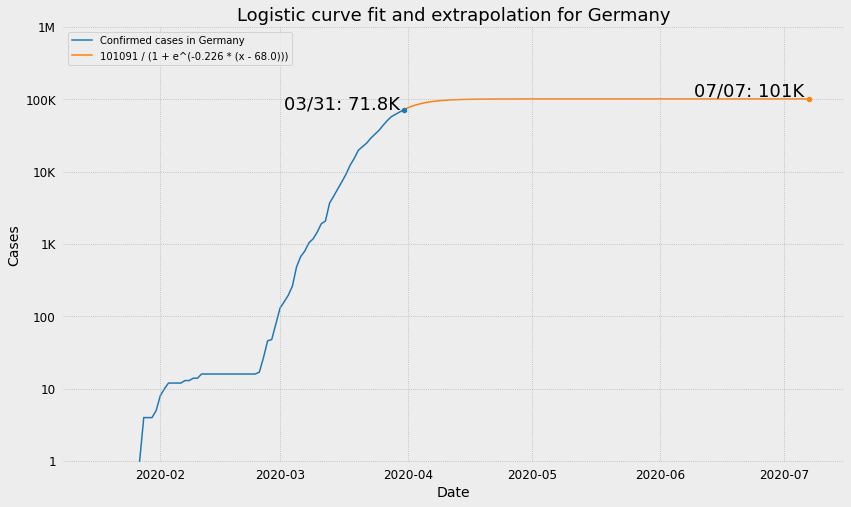

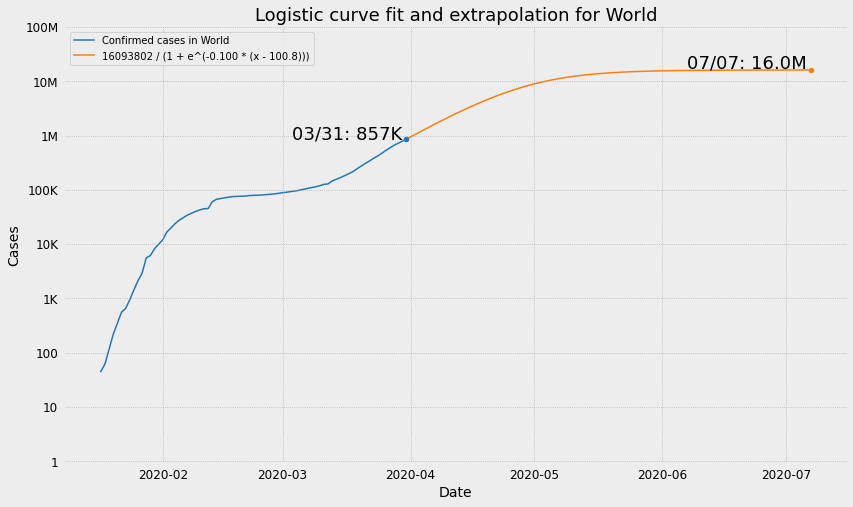

In [15]:
data.curve_fit("United States", days=100)
data.curve_fit("Germany", days=100)
data.curve_fit("World", days=100)

### Modelling fatality probability per day of being infected

[Source](https://www.mdpi.com/2077-0383/9/2/538). This models the *hospitalization to death* distribution, because confirmed cases in the JHU dataset are not backdated to the onset of symptoms.

Input CFR: 4.00%. Model result: 96.00% of being alive after 30 days

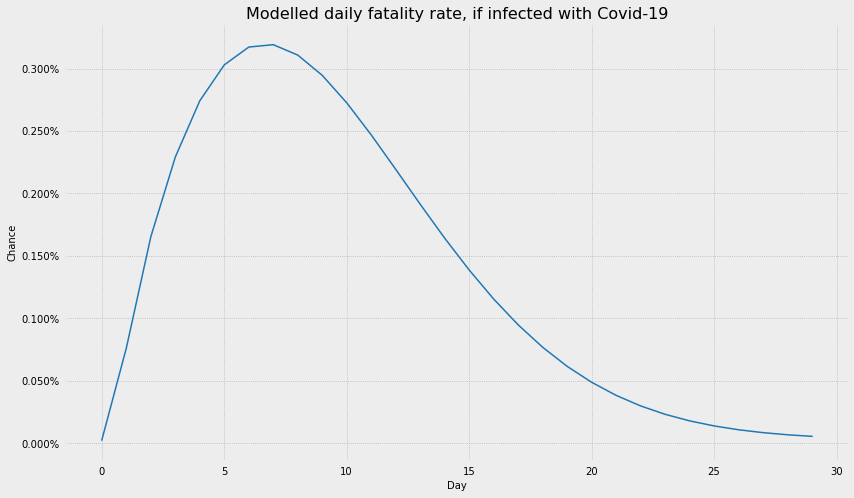

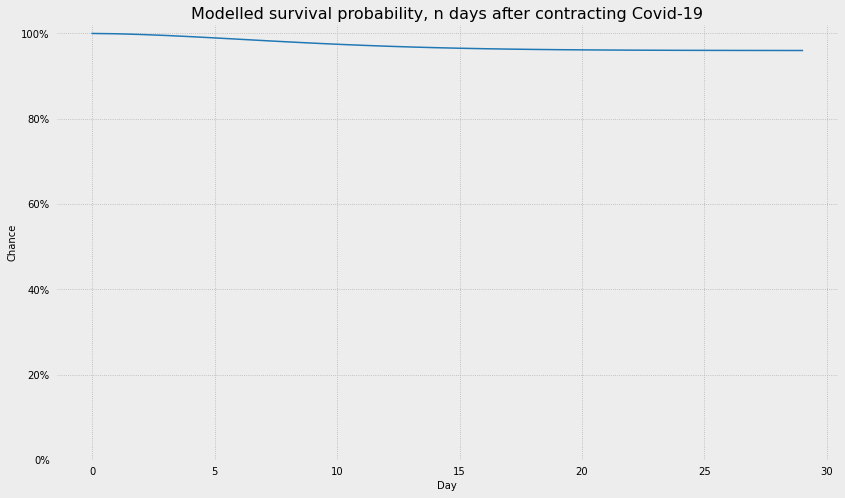

In [16]:
death_chance_per_day(cfr=0.04, s=1.75, mu=0.5, sigma=10, length=30, do_plot=True)

### Generate history of active cases; how many people have been sick for how long?

Data on **how long** people have been sick is not available, so it is reconstructed using the observed distribution of deaths by case duration.

In [17]:
data.simulate_country_history(country="United States", history_length=7, show_result=True);

<br>**Last 10 days in United States, showing a 7-day case duration history:**

,confirmed,deaths,recovered,active,uninfected,active_0,active_1,active_2,active_3,active_4,active_5,active_6
2020-03-22,33276,417,4621,29768,310199587,7786,6388,5422,5892,1360,1786,1130
2020-03-23,43847,557,6406,39203,310189016,10570,7786,6388,5421,5891,1359,1785
2020-03-24,53740,706,7764,47304,310179123,9892,10570,7785,6387,5420,5890,1357
2020-03-25,65778,942,13652,57975,310167085,12037,9892,10569,7784,6385,5418,5888
2020-03-26,83836,1209,19067,70134,310149027,18057,12037,9891,10567,7782,6382,5415
2020-03-27,101657,1581,25447,82524,310131206,17820,18057,12035,9888,10564,7778,6379
2020-03-28,121478,2026,33221,95948,310111385,19820,17819,18054,12032,9884,10560,7774
2020-03-29,140886,2467,43778,107564,310091977,19407,19819,17817,18051,12028,9881,10556
2020-03-30,161807,2978,53654,117907,310071056,20920,19406,19817,17814,18047,12024,9876
2020-03-31,188172,3873,65670,134360,310044691,26364,20918,19402,19811,17807,18039,12015


### Simulate future development based on history and probability models

This shows 3 simulations with the only difference being the effectiveness of lockdowns and other mitigation efforts.

1. Effective lockdown: Assumes normal conditions at the start, followed by a quick and very strict lockdown for as long as it takes. This is the best case, but in my opinion somewhat unlikely.
2. Ineffective lockdown: A late and halfhearted attempt at a lockdown is done, but the virus keeps spreading at a half speed. This would be pretty bad; most of the population would be infected before a vaccine is likely to be available.
3.  Prolonged battle: Alternating periods of strict lockdowns with more relaxed periods softens the blow to the economy, and stalls the number of infections until a vaccine can hopefully be developed, or until eventually, herd immunity kicks in.

Please note that this is *very* speculative, and highly dependent on:

* The value chosen for the mitigation factor. Together with R<sub>0</sub>, this represents the reduction in spread based on the effectives of quarantines, lockdowns and other countermeasures, and determines the effective reproductive rate R<sub>eff</sub> . For example, a mitigation factor of 0.7 means the disease spreads 70% as fast as it would without any countermeasures. If R<sub>0</sub> is 2, the mitigation factor is 0.8, and 98% of the population has not yet been infected,  
R<sub>eff</sub> = 2 \* 0.8 \* 0.98 = 1.568,  
meaning that effectively, every 1000 infected people will spread the disease to an average of 1568 uninfected people. 
<br><br>The input for mitigation factor is a list that gets interpolated to the same length as the number of days to simulate. <br><br>For example, simulating 5 days with a mitigation trend of `[1.0, 0.8]` will use growth rates of `[1.0, 0.95, 0.90, 0.85, 0.80]`.


* The value chosen for case fatality rate (cfr); evidence so far suggests a range from 0.01 to 0.06


Other limitations of the simulation:

* Doesn't consider incubation time 
* Doesn't factor in international travel and potential recontamination/reseeding for second and later waves.
* Doesn't consider effect on death rate when the number of active cases overwhelms capacity (**TODO**)

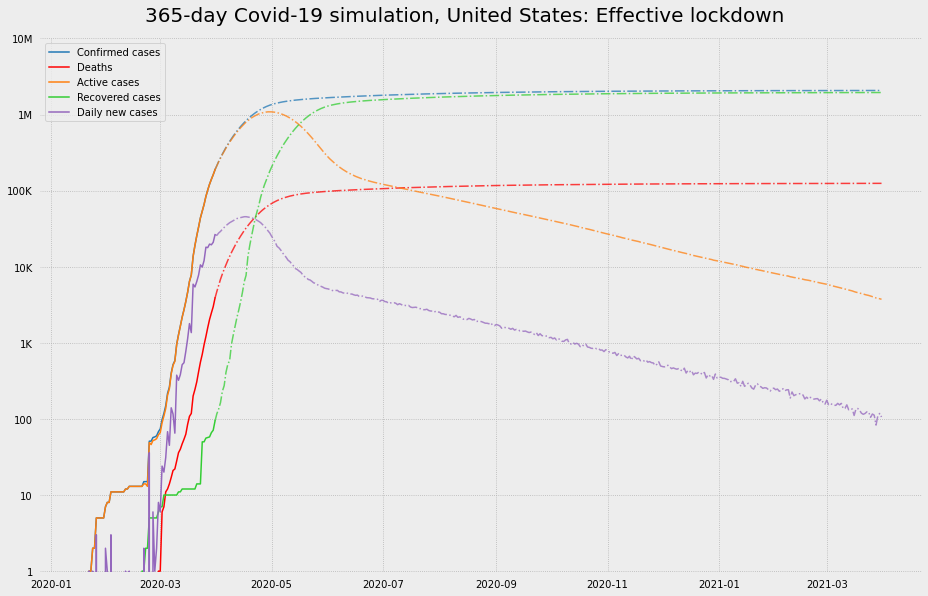

### Effective lockdown final tally:

Confirmed: 2.06M,
Deaths: 124K,
Recovered: 1.94M,
Peak active: 1.08M at 2020-04-30,
Uninfected: 308M


In [18]:
S = 0.20              # mitigation effectiveness under severe lockdown
M = 0.30              # mitigation effectiveness under moderate lockdown
W = 0.50              # mitigation effectiveness under weak lockdown
N = 1.00              # mitigation effectiveness under normal conditions

# Values inspired by the mitigation effectiveness analysis below
I = 0.31   # Italy, Iran
C = 0.22   # China
K = 0.175  # South Korea

cfr = 0.06 # https://arxiv.org/abs/2003.09320
r0 = 3.1   # https://arxiv.org/abs/2003.09320

scenarios = {
    "Effective lockdown":   [W,S,I,I,I,I,I,I,I,I,I,I],
    "Ineffective lockdown": [N,W,W,W],
    "Prolonged battle":     [M,M,W,S,M,M,W,S,M,M,W,S]
}

scenario = "Effective lockdown"
simulation = data.plot_simulation(country="United States", days = 365, 
                                  mitigation_trend=scenarios[scenario], 
                                  cfr=cfr, r0=r0, scenario_name=scenario)

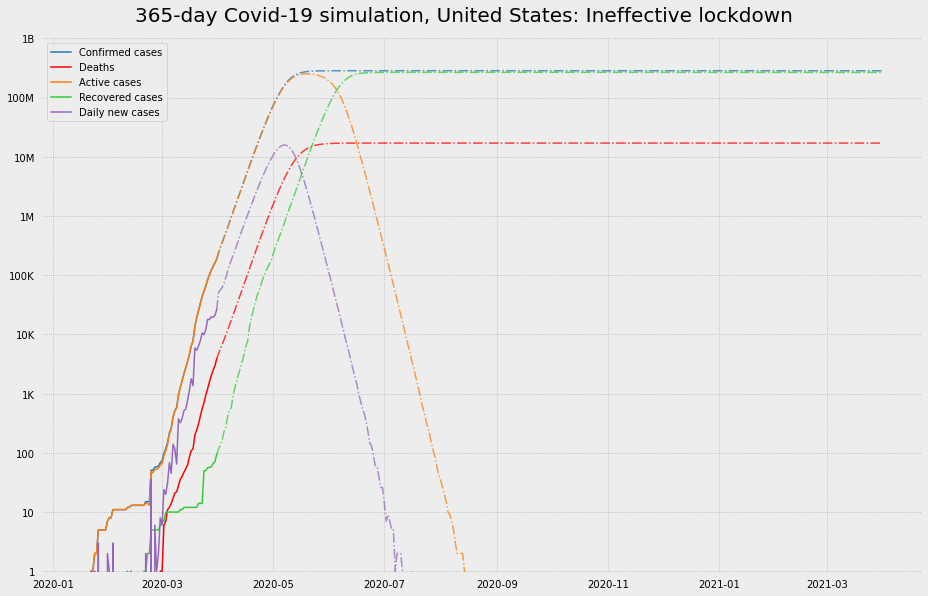

### Ineffective lockdown final tally:

Confirmed: 284M,
Deaths: 17.0M,
Recovered: 267M,
Peak active: 252M at 2020-05-20,
Uninfected: 25.8M


In [19]:
scenario = "Ineffective lockdown"
simulation = data.plot_simulation(country="United States", days = 365,
                                  mitigation_trend=scenarios[scenario], 
                                  cfr=0.06, r0=3.1, scenario_name=scenario)

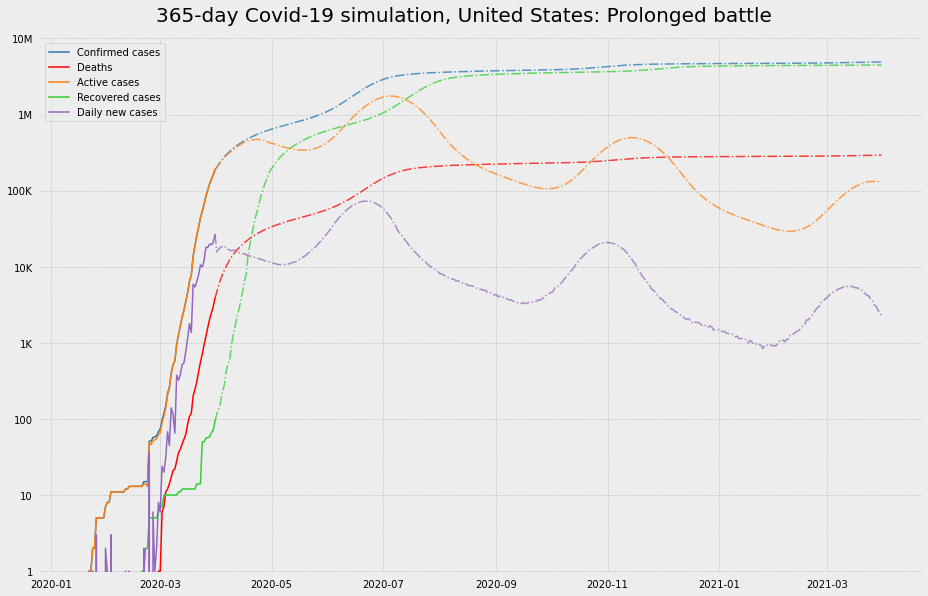

### Prolonged battle final tally:

Confirmed: 4.89M,
Deaths: 292K,
Recovered: 4.47M,
Peak active: 1.74M at 2020-07-05,
Uninfected: 305M


In [20]:
scenario = "Prolonged battle"
simulation = data.plot_simulation(country="United States", days = 365, 
                                  mitigation_trend=scenarios[scenario], 
                                  cfr=0.06, r0=3.1, scenario_name=scenario)

### Mitigation effectiveness

Simulation of developments after the start of lockdowns and other countermeasures in some countries that were affected early.

By comparing the actual course of events with those of simulations with different mitigation effectiveness, we can approximate how effective the real countermeasures were.

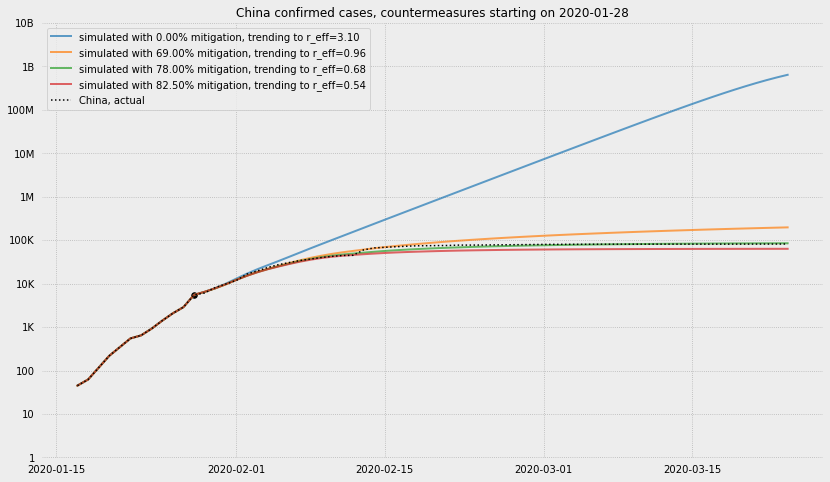

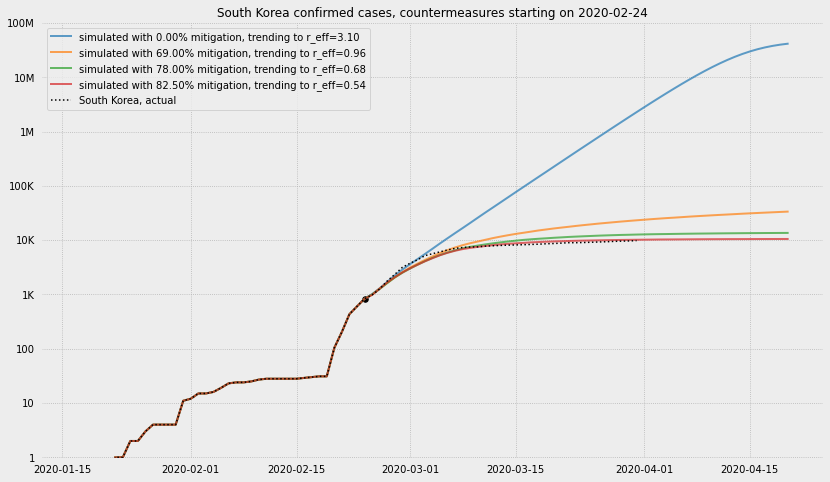

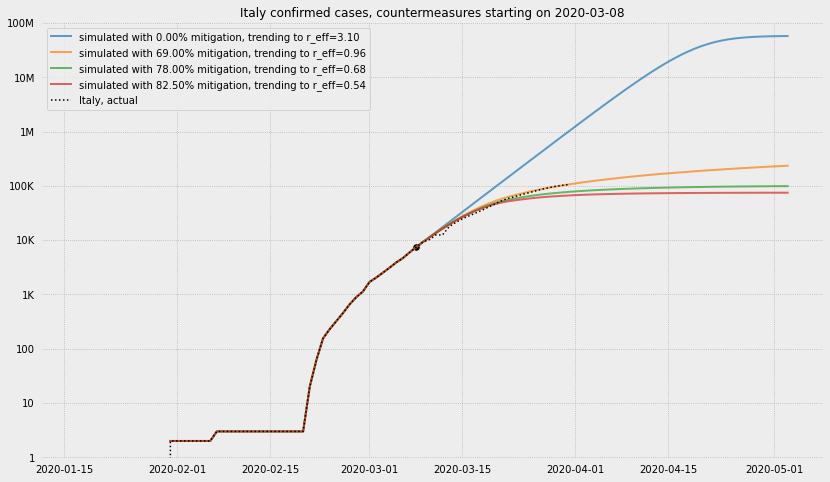

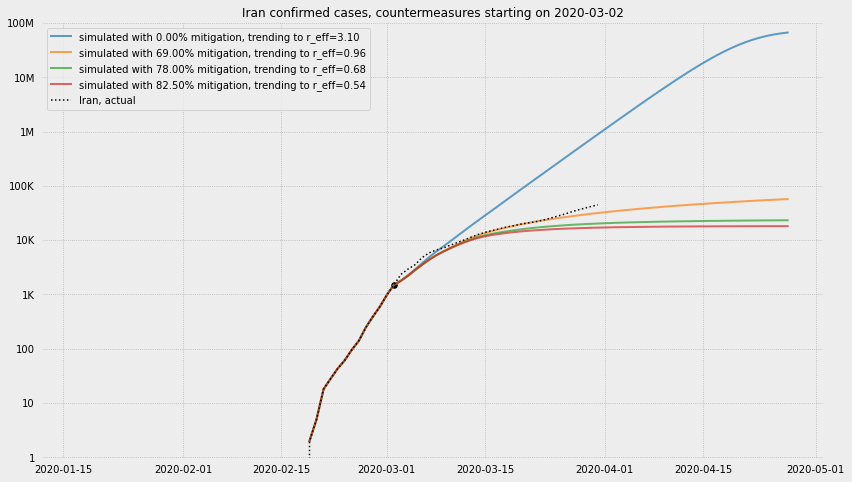

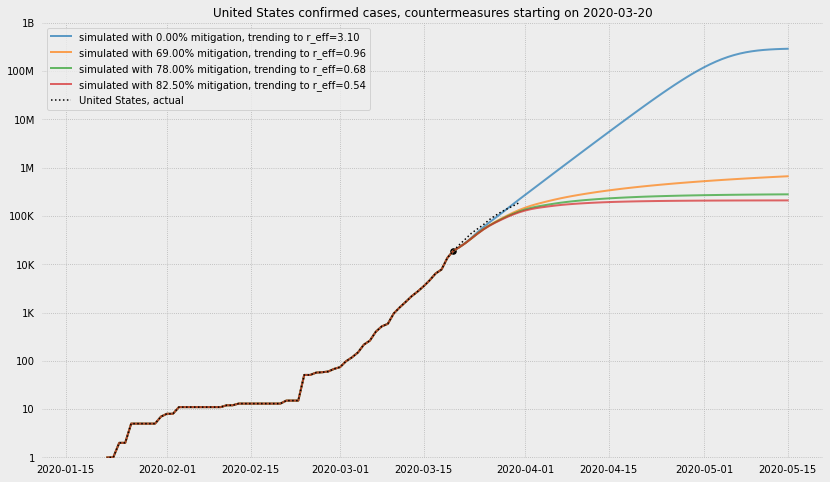

In [21]:
cfr = 0.04
r0 = 3.1

country_start_days = {
    "China": 9,
    "South Korea": 33,
    "Italy": 37,
    "Iran": 12,
    "United States": 58
}

for country in country_start_days:
    s = country_start_days[country]
    for i, f in enumerate([1.0, 0.31, 0.22, 0.175]):
        r_eff = r0 * f        
        sim, today = data.simulate_country(country, days=56, cfr=cfr, r0=r0, from_day=s, mitigation_trend=[1]+4*[f])
        actual, _ = data.simulate_country(country, days=0, cfr=cfr, r0=r0, from_day=-1, mitigation_trend=[1])
        
        plt.plot(sim.confirmed, label=f"simulated with {1-f:.2%} mitigation, trending to "+
                 f"r_eff={r_eff:.2f}", linestyle="-", lw=2, alpha=0.7)
        
    plt.plot(actual.confirmed[actual.confirmed.index <= sim.index[-1]], ":", label=f"{country}, actual", c="k")
    plt.scatter(today, sim.confirmed[today], c="k", s=30)
    plt.grid()
    plt.legend()
    set_y_axis_format(actual.max().max(), True)
    plt.title(f"{country} confirmed cases, countermeasures starting on {today.date()}")
    plt.show()